In [1]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import torch.nn.functional as F 

# Parameters

In [2]:
alpha = 0.01                        # parameter of air friction
g = 9.8                             # gravity acceleration

n = 100                             # generate n trajectories for training

learning_rate = 0.02

t = np.linspace(0,1, 10001)         
dt = 0.0001

x_np_M=0                           
y_np_M=0
z_np_M=0
vx_np_M=0
vy_np_M=0
vz_np_M=0
ax_np_M=0
ay_np_M=0
az_np_M=0

# Generate training data

In [3]:
for i in range(n):
    x = [rd.uniform(-2,2)]
    y = [rd.uniform(-2,2)]
    z = [rd.uniform(1,2)]
    vx = [rd.uniform(7,11)]
    vy = [rd.uniform(-2,2)]
    vz = [rd.uniform(3,6)]
    ax = []
    ay = []
    az = []
    for step in t:
        v = np.sqrt(vx[-1]*vx[-1] + vy[-1]*vy[-1] + vz[-1]*vz[-1])
        ax.append(-alpha*v*vx[-1])
        ay.append(-alpha*v*vy[-1])
        az.append(-g - alpha*v*vz[-1])

        if step == 1:
            break
            
        x.append(x[-1] + vx[-1]*dt)
        y.append(y[-1] + vy[-1]*dt)
        z.append(z[-1] + vz[-1]*dt)

        vx.append(vx[-1] + ax[-1]*dt)
        vy.append(vy[-1] + ay[-1]*dt)
        vz.append(vz[-1] + az[-1]*dt)
        
    x_np = np.asarray(x)
    y_np = np.asarray(y)
    z_np = np.asarray(z)
    vx_np = np.asarray(vx)
    vy_np = np.asarray(vy)
    vz_np = np.asarray(vz)
    ax_np = np.asarray(ax)
    ay_np = np.asarray(ay)
    az_np = np.asarray(az)    
    
    global x_np_M, y_np_M, z_np_M, vx_np_M, vy_np_M, vz_np_M, ax_np_M, ay_np_M, az_np_M

    if isinstance(x_np_M,int):
        x_np_M = x_np
        y_np_M = y_np
        z_np_M = z_np
        vx_np_M = vx_np
        vy_np_M = vy_np
        vz_np_M = vz_np
        ax_np_M = ax_np
        ay_np_M = ay_np
        az_np_M = az_np
    else:
        x_np_M = np.vstack((x_np_M, x_np))
        y_np_M = np.vstack((y_np_M, y_np))
        z_np_M = np.vstack((z_np_M, z_np))
        vx_np_M = np.vstack((vx_np_M, vx_np))
        vy_np_M = np.vstack((vy_np_M, vy_np))
        vz_np_M = np.vstack((vz_np_M, vz_np))
        ax_np_M = np.vstack((ax_np_M, ax_np))
        ay_np_M = np.vstack((ay_np_M, ay_np))
        az_np_M = np.vstack((az_np_M, az_np))

### Convert shape of training data

In [4]:
s = np.linspace(0, 10000, 101)
input_np_M = 0
output_np_M = 0
for i in range(100):
    for j in s:
        j = int(j)
        input_ = [x_np_M[i][j], y_np_M[i][j], z_np_M[i][j], vx_np_M[i][j], vy_np_M[i][j], vz_np_M[i][j]]
        input_np = np.asarray(input_)
        
        output_ = [ax_np_M[i][j], ay_np_M[i][j], az_np_M[i][j]]
        output_np = np.asarray(output_)
        
        global input_np_M, output_np_M
        if isinstance(input_np_M, int):
            input_np_M = input_
            output_np_M = output_
        else:
            input_np_M = np.vstack((input_np_M, input_))
            output_np_M = np.vstack((output_np_M, output_))

### Shape of training data

In [5]:
print(np.shape(x_np_M))
print(np.shape(input_np_M))
print(np.shape(output_np_M))

(100, 10001)
(10100, 6)
(10100, 3)


# Model training & test
### Defination of neural network

In [6]:
class Network(th.nn.Module):
    def __init__(self, n_input, n_hidden_1, n_hidden_2, n_output):
        super(Network, self).__init__()
        
        self.bn_input = th.nn.BatchNorm1d(n_input, momentum=0.5)
        self.hidden_1 = th.nn.Linear(n_input, n_hidden_1)
        self.bn_1 = th.nn.BatchNorm1d(n_hidden_1, momentum=0.5)
        self.hidden_2 = th.nn.Linear(n_hidden_1, n_hidden_2)
        self.bn_2 = th.nn.BatchNorm1d(n_hidden_2, momentum=0.5)
        self.predict = th.nn.Linear(n_hidden_2, n_output)   

    def forward(self, x):   
        x = self.bn_input(x)
        x = self.hidden_1(x)
        x = th.tanh(self.bn_1(x))
        
        x = self.hidden_2(x)
        x = th.tanh(self.bn_2(x))
        x = self.predict(x)             
        return x

### Training NN

In [7]:
predictor = Network(n_input=6, n_hidden_1=64, n_hidden_2 = 64, n_output=3)

print(predictor)

Network(
  (bn_input): BatchNorm1d(6, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (hidden_1): Linear(in_features=6, out_features=64, bias=True)
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (hidden_2): Linear(in_features=64, out_features=64, bias=True)
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (predict): Linear(in_features=64, out_features=3, bias=True)
)


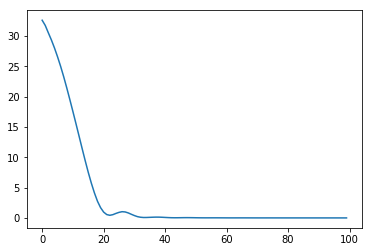

In [8]:
input_T = th.from_numpy(input_np_M)
output_T = th.from_numpy(output_np_M)

optimizer = th.optim.Adam(predictor.parameters(), lr=learning_rate, betas=(0.9, 0.99))
loss_func = th.nn.MSELoss()      

loss_his = []

for i in range(100):
    prediction = predictor(input_T.float())     
    loss = loss_func(prediction, output_T.float())     
    
    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()   
    
    loss_his.append(loss.data.numpy())
plt.figure()
plt.plot(range(100),loss_his)
plt.show()

In [9]:
print(loss_his[-1])

0.003208533860743046


### Test model

In [15]:
# init arrays for predicting trajectory
x_predict = [x_np_M[1][0]]
y_predict = [y_np_M[1][0]]
z_predict = [z_np_M[1][0]]
vx_predict = [vx_np_M[1][0]]
vy_predict = [vy_np_M[1][0]]
vz_predict = [vz_np_M[1][0]]
ax_predict = []
ay_predict = []
az_predict = []
predictor.eval()
in_test = th.FloatTensor(1,6).zero_()

In [16]:
# Iteratively predict trajectory
for step in t:
    in_test[0][0] = x_predict[-1]
    in_test[0][1] = y_predict[-1]
    in_test[0][2] = z_predict[-1]
    in_test[0][3] = vx_predict[-1]
    in_test[0][4] = vy_predict[-1]
    in_test[0][5] = vz_predict[-1]
    a = predictor(in_test)
    
    ax_predict.append(a.data.numpy()[0][0])
    ay_predict.append(a.data.numpy()[0][1])
    az_predict.append(a.data.numpy()[0][2])

    if step == 1:
        break

    x_predict.append(x_predict[-1] + vx_predict[-1]*dt)
    y_predict.append(y_predict[-1] + vy_predict[-1]*dt)
    z_predict.append(z_predict[-1] + vz_predict[-1]*dt)

    vx_predict.append(vx_predict[-1] + ax_predict[-1]*dt)
    vy_predict.append(vy_predict[-1] + ay_predict[-1]*dt)
    vz_predict.append(vz_predict[-1] + az_predict[-1]*dt)

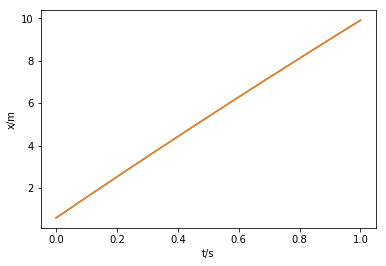

1.29275588669


In [17]:
# plost x-t
plt.figure()
plt.plot(t, x_np_M[1])
plt.plot(t, x_predict)
plt.xlabel('t/s')
plt.ylabel('x/m')
plt.show()
print(x_np_M[0][10000] - x_predict[10000])

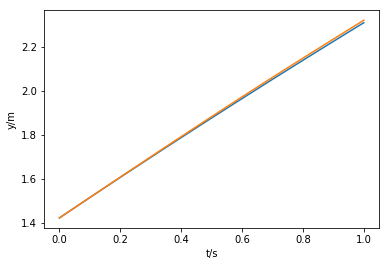

-0.0112306161264


In [19]:
# plot y-t
plt.figure()
plt.plot(t, y_np_M[1])
plt.plot(t, y_predict)
plt.xlabel('t/s')
plt.ylabel('y/m')
plt.show()
print(y_np_M[1][10000] - y_predict[10000])

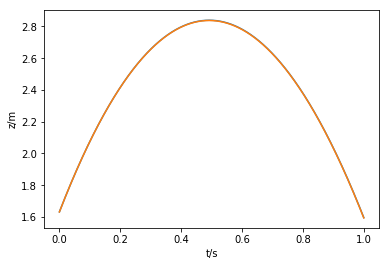

0.00202918749516


In [20]:
# plot z-t
plt.figure()
plt.plot(t, z_np_M[1])
plt.plot(t, z_predict)
plt.xlabel('t/s')
plt.ylabel('z/m')
plt.show()
print(z_np_M[1][10000] - z_predict[10000])